# Intro to Machine Learning Workshop: Act 2

This notebook is part of an Intro to Machine Learning workshop. It is an annotated version of the live coding example that formed the second half of the workshop.

---

## Fizz Buzz with Machine Learning

[_Fizz Buzz_][1] is a children's counting game, where each person in turn says a number, counting up from 1. If the number is divisible by 3, instead of saying the number you say _fizz_; if the number is divisible by 5, instead of saying the number you say _buzz_; if the number is divisible by both 3 and 5, you say _fizz buzz_.

[1]: https://en.wikipedia.org/wiki/Fizz_buzz

### Non-ML approach

_Fizz buzz_ can be implemented in a few lines of code in most languages, and we certainly don't need machine learning to solve this problem. Here's an example.

In [104]:
def fizzbuzz(number):
    fizz = (number % 3 == 0)
    buzz = (number % 5 == 0)
    
    if fizz and buzz:
        return 'fizzbuzz'
    elif fizz:
        return 'fizz'
    elif buzz:
        return 'buzz'
    else:
        return str(number)

In [105]:
for number in range(1, 16):
    print(fizzbuzz(number))

1
2
fizz
4
buzz
fizz
7
8
fizz
buzz
11
fizz
13
14
fizzbuzz


## ML approach

Just for fun, let's see if we can a machine learning model to play _fizz buzz_ for us. Our goal is to write a program that can produce the correct output without us ever explicitly writing down the rules of _fizz buzz_, instead we want it to learn the rules from examples.

### Gathering examples

The first stage of a supervised learning problem is to gather examples. Since we already have a working example of `fizzbuzz` we can cheat, and generate our examples automatically. We'll start with random numbers, and the output of the `fizzbuzz` function we've already written.

In [107]:
import random
import pandas as pd

n_examples = 100_000
example_numbers = random.sample(range(1, 1_000_001), n_examples)
examples = pd.DataFrame(
    [(n, fizzbuzz(n)) for n in example_numbers],
    columns=['n', 'fizzbuzz'],
)

examples.head()

,n,fizzbuzz
0,71591,71591
1,780775,buzz
2,387672,fizz
3,327619,327619
4,103935,fizzbuzz


### Feature engineering

Now that we have our raw example data, we need to massage it into a form that's appropriate to how machine learning algorithms see the world. For each example we have, we want to represent it as a set of input features (things we know about the example) and target features (things we want the model to learn).

Machine learning algorithms tend not to deal well with complex representations like text, useful features tend to be to be either continuous (numerical values) or boolean (yes or no). More complex features usually need to be distilled to one of those types before they can be used.

Let's start by dealing with our target features: we want our model to learn if it should say `fizz`, `buzz`, `fizzbuzz` or the number. We can distil those four categories down to two booleans: is this a fizz, and is this a buzz.

In [108]:
examples['fizz'] = examples['fizzbuzz'].str.contains('fizz')
examples['buzz'] = examples['fizzbuzz'].str.contains('buzz')
examples.head()

,n,fizzbuzz,fizz,buzz
0,71591,71591,False,False
1,780775,buzz,False,True
2,387672,fizz,True,False
3,327619,327619,False,False
4,103935,fizzbuzz,True,True


We only have one input feature that matters: the number itself. However, we can still think about how this is represented. A common trick when trying to classify numbers, as we're doing here, is to represent the numbers in binary and treat each bit as a separate input feature. Let's try that here.

In [134]:
def bits(number, n_bits=32):
    binary = format(number, 'b').zfill(n_bits)
    return [int(bit) for bit in binary]

bit_columns = ['b{}'.format(n) for n in range(32)]

bit_features = pd.DataFrame(
    np.array([bits(n) for n in examples['n']]),
    columns=bit_columns,
)

examples = pd.concat([examples, bit_features], axis=1)
examples.head()

,n,fizzbuzz,fizz,buzz,b0,b1,b2,b3,b4,b5,...,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31
0,71591,71591,False,False,0,0,0,0,0,0,...,1,1,1,0,1,0,0,1,1,1
1,780775,buzz,False,True,0,0,0,0,0,0,...,0,1,1,1,1,0,0,1,1,1
2,387672,fizz,True,False,0,0,0,0,0,0,...,1,0,0,1,0,1,1,0,0,0
3,327619,327619,False,False,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,1,1
4,103935,fizzbuzz,True,True,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1


### Training and testing sets

Now that we've got the data into a useful form, we can partition it into a _training set_ and a _test set_. The training set will contain the examples we'll use to train the machine learning model. The test set will contain a completely distinct set of values we'll use to verify that the model is working well after it's been trained.

In [135]:
from sklearn.model_selection import train_test_split

training_examples, test_examples = train_test_split(examples, test_size=0.2)

We can take a quick look at our training and test sets, to make sure they both contain values from all of the classes we're interested in.

In [136]:
training_examples.groupby(['fizz', 'buzz']).size()

fizz   buzz 
False  False    42789
       True     10697
True   False    21227
       True      5287
dtype: int64

In [137]:
test_examples.groupby(['fizz', 'buzz']).size()

fizz   buzz 
False  False    10784
       True      2590
True   False     5270
       True      1356
dtype: int64

### Model training

We're going to use a neural network model to try to play fizz buzz for us. The inputs will be the binary digits of the number, we'll use one hidden layer with 64 nodes, and the outputs will be the probability that we should say _fizz_, and the probability that we should say _buzz_.

```
bit1  -
       \ - hidden1  -
bit2  -\             \
       \ - hidden2  -\ - prob_fizz
bit3  -\             \
       \ -    …     -\ - prob_buzz
 …    -\             /
       / - hidden64 -
bit32 -
```

In [138]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(
    hidden_layer_sizes=(32,),
    max_iter=1000,
    verbose=True,
)

In [139]:
classifier.fit(
    training_examples[bit_columns].values,
    training_examples[['fizz', 'buzz']].values,
)

Iteration 1, loss = 1.16095253
Iteration 2, loss = 1.13831105
Iteration 3, loss = 1.13683652
Iteration 4, loss = 1.13619210
Iteration 5, loss = 1.13583691
Iteration 6, loss = 1.13546507
Iteration 7, loss = 1.13516467
Iteration 8, loss = 1.13502291
Iteration 9, loss = 1.13472343
Iteration 10, loss = 1.13454308
Iteration 11, loss = 1.13443585
Iteration 12, loss = 1.13410880
Iteration 13, loss = 1.13398137
Iteration 14, loss = 1.13338520
Iteration 15, loss = 1.13323169
Iteration 16, loss = 1.13308595
Iteration 17, loss = 1.13279563
Iteration 18, loss = 1.13267955
Iteration 19, loss = 1.13233035
Iteration 20, loss = 1.13207137
Iteration 21, loss = 1.13188404
Iteration 22, loss = 1.13157728
Iteration 23, loss = 1.13143042
Iteration 24, loss = 1.13112530
Iteration 25, loss = 1.13103748
Iteration 26, loss = 1.13082556
Iteration 27, loss = 1.13083082
Iteration 28, loss = 1.13065733
Iteration 29, loss = 1.13040874
Iteration 30, loss = 1.13045878
Iteration 31, loss = 1.13029622
Iteration 32, los

Iteration 253, loss = 0.71641208
Iteration 254, loss = 0.71449609
Iteration 255, loss = 0.71316274
Iteration 256, loss = 0.71220980
Iteration 257, loss = 0.71012375
Iteration 258, loss = 0.70772264
Iteration 259, loss = 0.70619108
Iteration 260, loss = 0.70398254
Iteration 261, loss = 0.70230158
Iteration 262, loss = 0.69970368
Iteration 263, loss = 0.69778306
Iteration 264, loss = 0.69581802
Iteration 265, loss = 0.69352427
Iteration 266, loss = 0.69122176
Iteration 267, loss = 0.68905364
Iteration 268, loss = 0.68648603
Iteration 269, loss = 0.68359372
Iteration 270, loss = 0.68112395
Iteration 271, loss = 0.67832565
Iteration 272, loss = 0.67560756
Iteration 273, loss = 0.67252143
Iteration 274, loss = 0.67036214
Iteration 275, loss = 0.66772208
Iteration 276, loss = 0.66472847
Iteration 277, loss = 0.66282553
Iteration 278, loss = 0.66063676
Iteration 279, loss = 0.65880722
Iteration 280, loss = 0.65630519
Iteration 281, loss = 0.65383839
Iteration 282, loss = 0.65197201
Iteration 

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(32,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

### Model evaluation

Now that we have a trained model, how do we know how we'll it's doing? A good measure for this kind of problem is the receiver operating characteristic (ROC) curve. The larger the area under the curve, the better the model is performing.

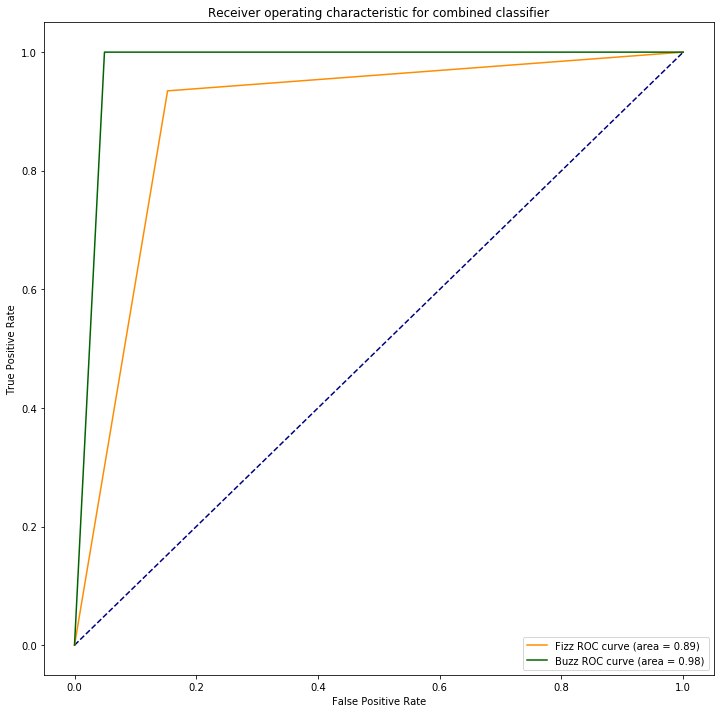

In [140]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

def plot_roc(predictions, expected, color, label):
    fpr, tpr, _ = roc_curve(predictions, expected)
    area_under_curve = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color=color,
        label='{} ROC curve (area = {:0.2f})'.format(label, area_under_curve),
    )


predictions = classifier.predict(test_examples[bit_columns].values)

plt.figure(figsize=(12, 12))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plot_roc(
    label='Fizz',
    predictions=predictions[:, 0],
    expected=np.array(test_examples['fizz']),
    color='darkorange',
)
plot_roc(
    label='Buzz',
    predictions=predictions[:, 1],
    expected=np.array(test_examples['buzz']),
    color='darkgreen',
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for combined classifier')
plt.legend(loc='lower right')
plt.show()

### Model usage

Now that we've trained and evaluated our model, we can put it into practice.

In [154]:
def fizzbuzz_ml(number):
    fizz, buzz = classifier.predict([bits(number)])[0]

    if fizz and buzz:
        return 'fizzbuzz'
    elif fizz:
        return 'fizz'
    elif buzz:
        return 'buzz'
    else:
        return str(number)

In [155]:
for number in range(1, 16):
    print(fizzbuzz_ml(number))

1
2
fizz
4
buzz
fizz
7
8
9
buzz
11
fizz
13
14
buzz


### Comparisson

Finally, let's take a look at the difference in output between our guarnateed correct implementation and our ML implementation (we normally won't be able to do this in a real-world problem, because the ML implementation will be the best we have—otherwise, why would we have built it at all?)

In [158]:
comparisson = pd.DataFrame(
    [(n, fizzbuzz(n), fizzbuzz_ml(n)) for n in range(1, 100_001)],
    columns=['n', 'correct', 'ml']
)
comparisson.head(15)

,n,correct,ml
0,1,1,1
1,2,2,2
2,3,fizz,fizz
3,4,4,4
4,5,buzz,buzz
5,6,fizz,fizz
6,7,7,7
7,8,8,8
8,9,fizz,9
9,10,buzz,buzz


In [159]:
diff = comparisson[comparisson['correct'] != comparisson['ml']]
diff.head(15)

,n,correct,ml
8,9,fizz,9
14,15,fizzbuzz,buzz
24,25,buzz,25
26,27,fizz,27
54,55,buzz,55
59,60,fizzbuzz,buzz
65,66,fizz,66
92,93,fizz,93
98,99,fizz,99
134,135,fizzbuzz,fizz


Here's the overall accuracy of our fizzbuzz machine over the first 100,000 numbers.

In [160]:
1 - len(diff) / len(comparisson)

0.83252